# Estimate a probability with FORM

In this basic example we are going to estimate a failure probability.

Let's consider the following analytical example of a cantilever beam, of Young's modulus E, length L, section modulus I.

One end is built in a wall and we apply a concentrated bending load F at the other end of the beam, resulting in a deviation:
$$d = \frac{F*L^3}{3*E*I}$$

It is considered that failure occurs when the beam deviation is too important:

$$d \ge 30 (cm) $$

Four independent random variables are considered:

 - E (the Young's modulus) [Pa]
 - F (the load) [N]
 - L (the length) # [m]
 - I (the section) # [m^4]

Stochastic model (simplified model, no units):

 - E ~ Beta(0.93, 3.2, 2.8e7, 4.8e7)
 - F ~ LogNormal(30000, 9000, 15000)
 - L ~ Uniform(250, 260)
 - I ~ Beta(2.5, 4.0, 3.1e2, 4.5e2)


In [1]:
from __future__ import print_function
import openturns as ot

In [2]:
# Create the marginal distributions of the parameters
dist_E = ot.Beta(0.93, 3.2, 2.8e7, 4.8e7)
dist_F = ot.LogNormalMuSigma(30000, 9000, 15000).getDistribution()
dist_L = ot.Uniform(250, 260)
dist_I = ot.Beta(2.5, 4.0, 3.1e2, 4.5e2)
marginals = [dist_E, dist_F, dist_L, dist_I]

In [3]:
# Create the Copula
RS = ot.CorrelationMatrix(4)
RS[2, 3] = -0.2
# Evaluate the correlation matrix of the Normal copula from RS
R = ot.NormalCopula.GetCorrelationFromSpearmanCorrelation(RS)
# Create the Normal copula parametrized by R
copula = ot.NormalCopula(R) 

In [4]:
# Create the joint probability distribution
distribution = ot.ComposedDistribution(marginals, copula)
distribution.setDescription(['E', 'F', 'L', 'I'])

In [5]:
# create the model
model = ot.SymbolicFunction(['E', 'F', 'L', 'I'], ['F*L^3/(3*E*I)'])

In [6]:
# create the event we want to estimate the probability
vect = ot.RandomVector(distribution)
G = ot.CompositeRandomVector(model, vect)
event = ot.Event(G, ot.Greater(), 30.0)
event.setName("deviation")

In [7]:
# Define a solver
optimAlgo = ot.Cobyla()
optimAlgo.setMaximumIterationNumber(1000)
optimAlgo.setMaximumAbsoluteError(1.0e-10)
optimAlgo.setMaximumRelativeError(1.0e-10)
optimAlgo.setMaximumResidualError(1.0e-10)
optimAlgo.setMaximumConstraintError(1.0e-10)

In [8]:
# Run FORM
algo = ot.FORM(optimAlgo, event, distribution.getMean())
algo.run()
result = algo.getResult()

In [9]:
# Probability
result.getEventProbability()

0.00670980426490075

In [10]:
# Hasofer reliability index
result.getHasoferReliabilityIndex()

2.472435078752299

In [11]:
# Design point in the standard U* space
result.getStandardSpaceDesignPoint()

class=Point name=Standard Space Design Point dimension=4 values=[-0.602386,2.31056,0.355794,-0.533677]

In [12]:
# Design point in the physical X space
result.getPhysicalSpaceDesignPoint()

class=Point name=Physical Space Design Point dimension=4 values=[3.03272e+07,61318.5,256.39,378.635]

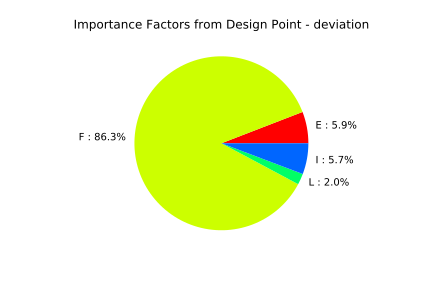

In [13]:
# Importance factors
result.drawImportanceFactors()

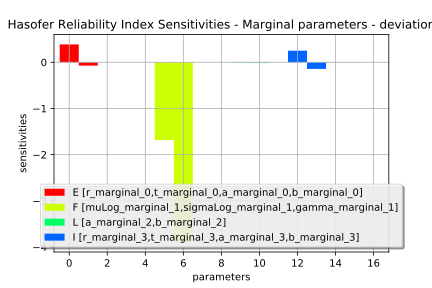

In [14]:
marginalSensitivity, otherSensitivity = result.drawHasoferReliabilityIndexSensitivity()
marginalSensitivity.setLegendPosition('bottom')
marginalSensitivity

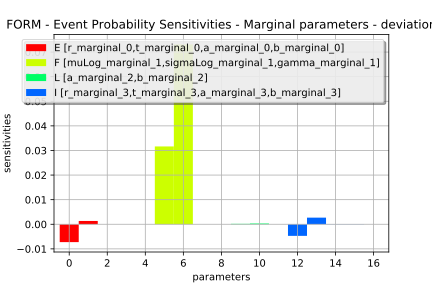

In [15]:
marginalSensitivity, otherSensitivity = result.drawEventProbabilitySensitivity()
marginalSensitivity

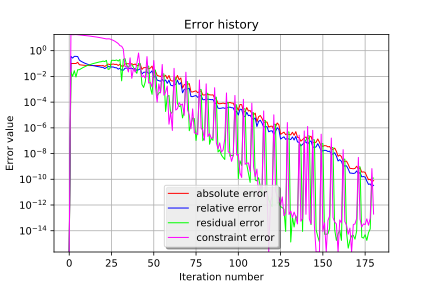

In [16]:
# Error history
optimResult = result.getOptimizationResult()
graphErrors = optimResult.drawErrorHistory()
graphErrors.setLegendPosition('bottom')
graphErrors.setYMargin(0.0)
graphErrors

In [17]:
# Get additional results with SORM
algo = ot.SORM(optimAlgo, event, distribution.getMean())
algo.run()
sorm_result = algo.getResult()

In [18]:
# Reliability index with Breitung approximation
sorm_result.getGeneralisedReliabilityIndexBreitung()

2.543869068257457

In [19]:
# ... with HohenBichler approximation
sorm_result.getGeneralisedReliabilityIndexHohenBichler()

2.551468863449899

In [20]:
# .. with Tvedt approximation
sorm_result.getGeneralisedReliabilityIndexTvedt()

2.5536673993057577

In [21]:
# SORM probability of the event with Breitung approximation
sorm_result.getEventProbabilityBreitung()

0.0054816085317681675

In [22]:
# ... with HohenBichler approximation
sorm_result.getEventProbabilityHohenBichler()

0.005363495427297016

In [23]:
# ... with Tvedt approximation
sorm_result.getEventProbabilityTvedt()

0.005329751264685826